![title](feature_types.png)

In [5]:
import pandas as pd

data_orig =  pd.read_csv("trinket_data_orig.csv", index_col=0)
y_orig = data_orig["price"]
X_orig = data_orig.drop("price", axis=1)

X_orig.head()

,color,age,weight,height,type_bar,type_foo,type_foobar
0,#e51e32,41,43.569090,68.784567,1.0,0.0,0.0
1,#f51a2f,71,84.261218,60.542412,0.0,0.0,1.0
2,#21e308,90,71.574072,45.595469,1.0,0.0,0.0
3,#0630cf,32,23.125698,83.431874,0.0,1.0,0.0
4,#04d82b,44,54.253466,20.646017,0.0,0.0,1.0


In [11]:
from pyreal.transformers import BaseTransformer, OneHotEncoder, DataFrameWrapper, Mappings, MappingsOneHotDecoder, FeatureSelectTransformer

class ColorTransformer(BaseTransformer):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, x_orig):
        return self

    def transform(self, x):
        for col in self.columns:
            x[col] = x[col].apply(hex_to_color_name)
        return x

class MaxAggregator(BaseTransformer):
    def __init__(self, columns):
        self.columns = columns

    def transform(self, x):
        column_name = "MAX("
        column_name += ",".join(self.columns)
        column_name += ")"
        x[column_name] = x[self.columns].max(axis=1)
        x = x.drop(self.columns, axis=1)
        return x

def hex_to_color_name(h):
    h = h.lstrip('#')
    rgb = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    return ["red", "green", "blue"][rgb.index(max(rgb))]

colorTransformer = ColorTransformer(columns = ["color"])
typeEncoder = OneHotEncoder(columns = ["type"])
colorEncoder = OneHotEncoder(columns = ["color"])
maxAggregator = MaxAggregator(columns=["weight", "height"])
mappings = Mappings.generate_mappings(categorical_to_one_hot={"type": {"type_foo": "foo", "type_bar": "bar", "type_foobar": "foobar"}})
typeDecoder = MappingsOneHotDecoder(mappings)
featureSelect = FeatureSelectTransformer(['age', 'type_bar', 'type_foo', 'type_foobar', 
                                          'color_blue', 'color_green', 'color_red', 
                                          'MAX(weight,height)'])

In [23]:
from pyreal.transformers import fit_transformers, run_transformers
from sklearn.linear_model import LinearRegression

e_transformers = [typeDecoder]
m_transformers = [colorTransformer, colorEncoder, maxAggregator, typeEncoder, featureSelect]
i_transformers = [typeDecoder, colorTransformer]

fit_transformers(e_transformers + m_transformers, X_orig)
fit_transformers(i_transformers, X_orig)

X_model = run_transformers(e_transformers + m_transformers, X_orig)
model = LinearRegression()
model.fit(X_model[0:400], y_orig[0:400])
print(model.score(X_model[401:], y[401:]))

0.9998228611356162


  color  age    weight     height type
0   red   41  43.56909  68.784567  bar


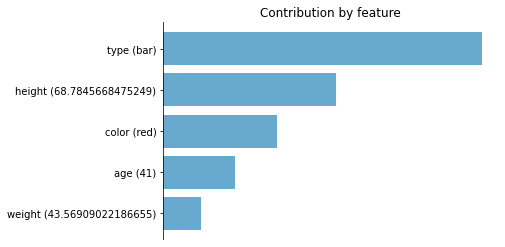

In [33]:
from pyreal.explainers.lfc import simple_counterfactual_contribution as scc
from pyreal.utils import visualize

explainer = scc.SimpleCounterfactualContribution(model, X_orig,
                                                 m_transforms=m_transformers,
                                                 e_transforms=e_transformers,
                                                 i_transforms=i_transformers,
                                                 fit_on_init=True)

explanation = explainer.produce(X_orig.iloc[0:1])
X_interpret = explainer.convert_data_to_interpretable(X_orig.iloc[0:1])
print(X_interpret)
visualize.plot_top_contributors(explanation, select_by="absolute", values=X_interpret.iloc[0])